Available metrics by category:

Duration:
  - total_time
  - dns_lookup
  - tcp_connection
  - tls_handshake
  - ttfb

Performance:
  - download_speed
  - upload_speed
  - hash_calculation_time

Reliability:
  - success
  - status_code
  - hash_match
  - size_match


/tmp/ipykernel_131020/2437226819.py:266: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


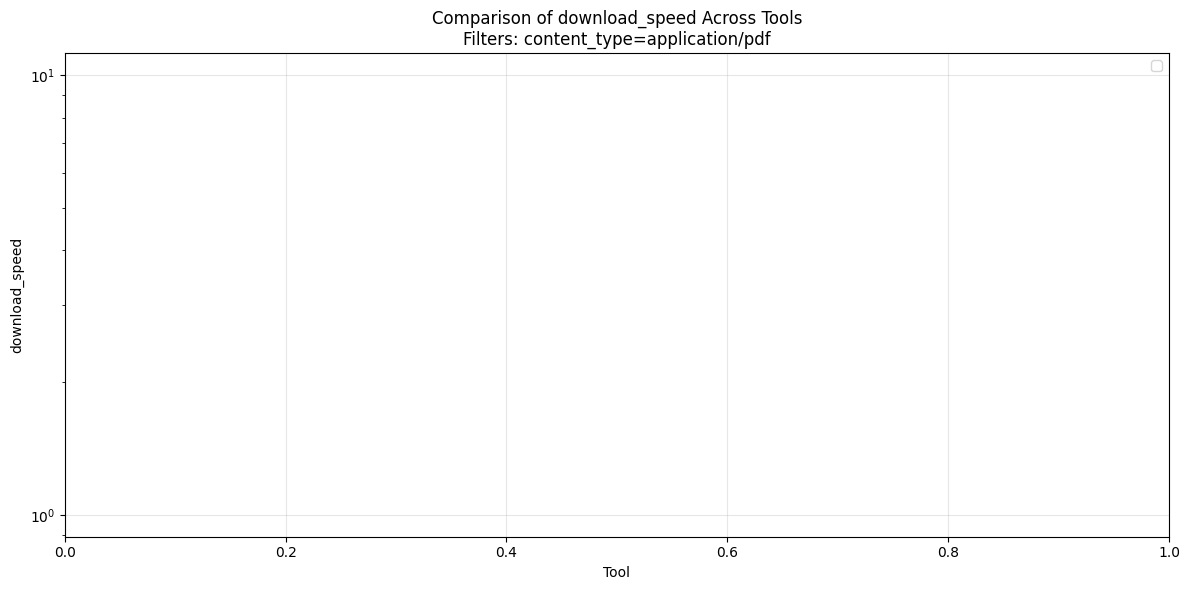

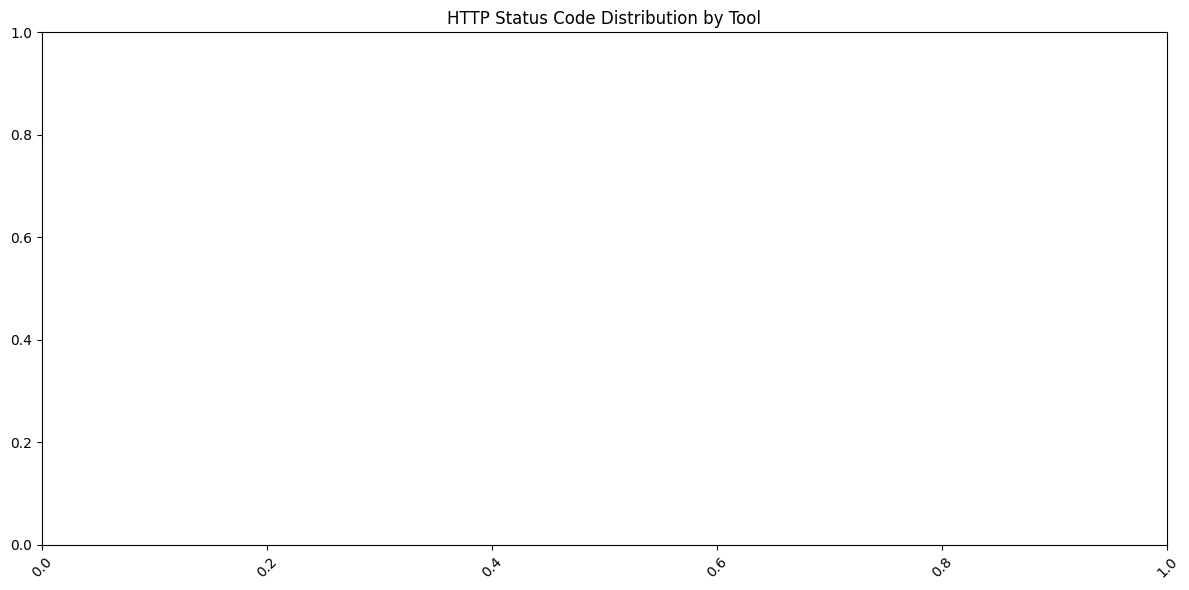

/tmp/ipykernel_131020/2437226819.py:325: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


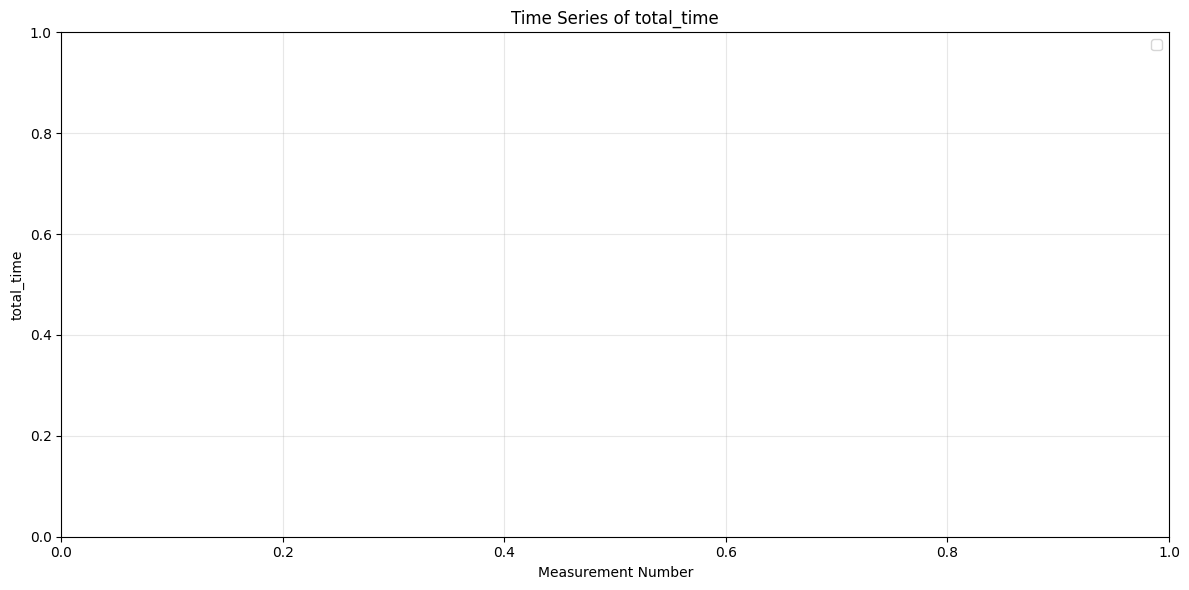

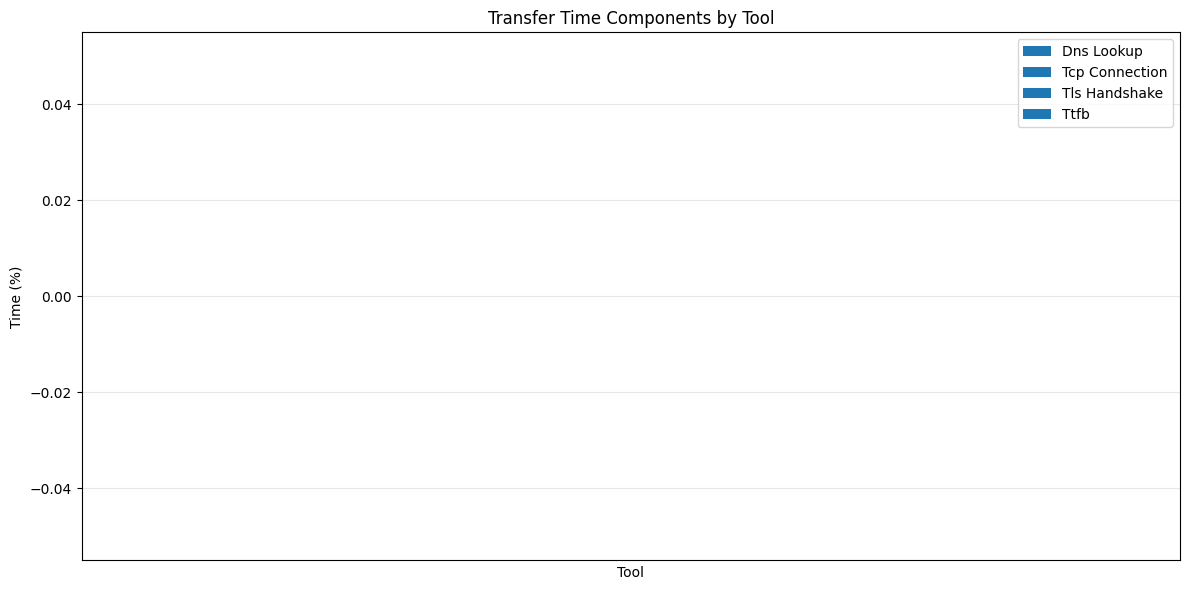


Detailed Statistics for Total Transfer Time:
Empty DataFrame
Columns: []
Index: []


In [2]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import List, Dict, Union, Optional
import warnings

class NetworkMeasurementAnalyzer:
    def __init__(self, data_dir: str):
        """
        Initialize the analyzer with a directory containing JSON measurement files.
        
        Args:
            data_dir (str): Path to directory containing measurement JSON files
        """
        self.data_dir = Path(data_dir)
        self.tools_data = {}
        self.load_all_data()
        
        # Define common metric groupings for easy access
        self.metric_groups = {
            'duration': [
                'total_time',
                'dns_lookup',
                'tcp_connection',
                'tls_handshake',
                'ttfb'
            ],
            'performance': [
                'download_speed',
                'upload_speed',
                'hash_calculation_time'
            ],
            'reliability': [
                'success',
                'status_code',
                'hash_match',
                'size_match'
            ]
        }
        
    def load_all_data(self):
        """Load all JSON files from the data directory"""
        for json_file in self.data_dir.glob('*.json'):
            tool_name = json_file.stem
            with open(json_file, 'r') as f:
                self.tools_data[tool_name] = json.load(f)
    
    def get_available_metrics(self) -> Dict[str, List[str]]:
        """
        Get all available metrics grouped by category
        
        Returns:
            Dict[str, List[str]]: Dictionary of metric categories and their metrics
        """
        return self.metric_groups
    
    def _extract_metrics_for_tool(self, tool_data: List[dict]) -> pd.DataFrame:
        """Extract metrics from raw tool data into a pandas DataFrame"""
        all_metrics = []
        
        for measurement in tool_data:
            measurement_num = measurement['measurementNumber']
            timestamp = measurement['timestamp']
            
            for transfer in measurement['fileTransfers']:
                metrics = {
                    'measurement_number': measurement_num,
                    'timestamp': pd.to_datetime(timestamp),
                    'filename': transfer['filename'],
                    'file_size': transfer['fileSize'],
                    'content_type': transfer['contentType'],
                    'success': transfer['transferSuccess'],
                    'status_code': transfer['statusCode'],
                    'download_speed': transfer['downloadSpeed'],
                    'upload_speed': transfer['uploadSpeed'],
                    'dns_lookup': transfer['dnsLookup'],
                    'tcp_connection': transfer['tcpConnection'],
                    'tls_handshake': transfer['tlsHandshake'],
                    'ttfb': transfer['timeToFirstByte'],
                    'total_time': transfer['totalTransferTime'],
                    'hash_match': transfer['hashMatch'],
                    'size_match': transfer['sizeMatch'],
                    'hash_calculation_time': transfer.get('hashCalculationTime', 0)
                }
                all_metrics.append(metrics)
                
        return pd.DataFrame(all_metrics)
    
    def get_tool_metrics(self, 
                        tool_names: Optional[Union[str, List[str]]] = None,
                        filter_conditions: Optional[Dict] = None) -> Dict[str, pd.DataFrame]:
        """
        Get metrics for specified tools with optional filtering
        
        Args:
            tool_names: Tool name(s) to analyze, or None for all tools
            filter_conditions: Dictionary of column names and values to filter by
                             e.g., {'filename': 'test.pdf', 'success': True}
            
        Returns:
            Dictionary of tool names to pandas DataFrames with their metrics
        """
        if tool_names is None:
            tool_names = list(self.tools_data.keys())
        elif isinstance(tool_names, str):
            tool_names = [tool_names]
            
        result = {}
        for tool in tool_names:
            if tool in self.tools_data:
                df = self._extract_metrics_for_tool(self.tools_data[tool])
                
                if filter_conditions:
                    for col, value in filter_conditions.items():
                        if col in df.columns:
                            df = df[df[col] == value]
                            
                result[tool] = df
                
        return result
    
    def analyze_metric(self, 
                      metric: str,
                      tool_names: Optional[Union[str, List[str]]] = None,
                      filter_conditions: Optional[Dict] = None,
                      percentiles: List[float] = [0, 25, 50, 75, 100]) -> pd.DataFrame:
        """
        Analyze a specific metric across tools
        
        Args:
            metric: Metric to analyze
            tool_names: Tool name(s) to analyze
            filter_conditions: Conditions to filter data by
            percentiles: Percentiles to calculate
            
        Returns:
            DataFrame with analysis results
        """
        tools_metrics = self.get_tool_metrics(tool_names, filter_conditions)
        results = []
        
        for tool, df in tools_metrics.items():
            data = df[metric]
            
            analysis = {
                'tool': tool,
                'count': len(data),
                'mean': data.mean(),
                'std': data.std(),
                'min': data.min(),
                'max': data.max()
            }
            
            # Add percentiles
            for p in percentiles:
                analysis[f'p{p}'] = np.percentile(data, p)
                
            # Add confidence intervals
            if len(data) > 1:
                ci = stats.t.interval(0.95, len(data)-1,
                                   loc=data.mean(),
                                   scale=stats.sem(data))
                analysis['ci_lower'] = ci[0]
                analysis['ci_upper'] = ci[1]
            
            results.append(analysis)
            
        return pd.DataFrame(results)
    
    def plot_metric_comparison(self,
                             metric: str,
                             tool_names: Optional[Union[str, List[str]]] = None,
                             filter_conditions: Optional[Dict] = None,
                             plot_type: str = 'boxplot',
                             log_scale: bool = False,
                             confidence_interval: float = 0.95,
                             show_failures: bool = True,
                             title: Optional[str] = None):
        """
        Plot comparison of a metric across tools
        
        Args:
            metric: Metric to compare
            tool_names: Tools to compare
            filter_conditions: Conditions to filter data by
            plot_type: Type of plot ('boxplot', 'violin', 'bar', 'scatter')
            log_scale: Whether to use log scale
            confidence_interval: Confidence interval level
            show_failures: Whether to show failed transfers
            title: Custom title for the plot
        """
        tools_metrics = self.get_tool_metrics(tool_names, filter_conditions)
        
        plt.figure(figsize=(12, 6))
        
        if plot_type == 'violin':
            data_list = []
            tool_list = []
            for tool, df in tools_metrics.items():
                data_list.extend(df[metric].tolist())
                tool_list.extend([tool] * len(df))
            
            sns.violinplot(x=tool_list, y=data_list)
            
        elif plot_type == 'scatter':
            for i, (tool, df) in enumerate(tools_metrics.items()):
                plt.scatter(df['measurement_number'], df[metric], 
                          label=tool, alpha=0.6)
                
        elif plot_type == 'bar':
            means = [df[metric].mean() for df in tools_metrics.values()]
            plt.bar(tools_metrics.keys(), means)
            
        else:  # default to boxplot
            positions = []
            labels = []
            
            for i, (tool, df) in enumerate(tools_metrics.items()):
                pos = i + 1
                
                if show_failures and 'success' in df.columns:
                    successful = df[df['success']]
                    failed = df[~df['success']]
                    
                    if len(successful) > 0:
                        plt.boxplot(successful[metric], positions=[pos],
                                  patch_artist=True,
                                  boxprops=dict(facecolor='lightblue'))
                        
                    if len(failed) > 0:
                        plt.scatter([pos] * len(failed),
                                  [0] * len(failed),
                                  marker='x', color='red', s=100,
                                  label=f'{tool} failures' if i == 0 else None)
                else:
                    plt.boxplot(df[metric], positions=[pos],
                              patch_artist=True,
                              boxprops=dict(facecolor='lightblue'))
                
                positions.append(pos)
                labels.append(tool)
            
            plt.xticks(positions, labels, rotation=45)
        
        # Set title
        if title is None:
            title = f'Comparison of {metric} Across Tools'
            if filter_conditions:
                filter_str = ', '.join(f'{k}={v}' for k, v in filter_conditions.items())
                title += f'\nFilters: {filter_str}'
        plt.title(title)
        
        plt.xlabel('Tool')
        plt.ylabel(metric)
        
        if log_scale:
            plt.yscale('log')
            
        plt.grid(True, alpha=0.3)
        if plot_type in ['scatter', 'violin']:
            plt.legend()
        plt.tight_layout()
        
        return plt
    
    def plot_status_distribution(self,
                               tool_names: Optional[Union[str, List[str]]] = None,
                               filter_conditions: Optional[Dict] = None):
        """Plot distribution of HTTP status codes for each tool"""
        tools_metrics = self.get_tool_metrics(tool_names, filter_conditions)
        
        plt.figure(figsize=(12, 6))
        
        data = []
        tools = []
        statuses = []
        
        for tool, df in tools_metrics.items():
            status_counts = df['status_code'].value_counts()
            for status, count in status_counts.items():
                data.append(count)
                tools.append(tool)
                statuses.append(str(status))
        
        df_plot = pd.DataFrame({
            'Tool': tools,
            'Status': statuses,
            'Count': data
        })
        
        sns.barplot(data=df_plot, x='Tool', y='Count', hue='Status')
        
        plt.title('HTTP Status Code Distribution by Tool')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        return plt

    def plot_time_series(self,
                        metric: str,
                        tool_names: Optional[Union[str, List[str]]] = None,
                        filter_conditions: Optional[Dict] = None,
                        rolling_window: Optional[int] = None):
        """Plot time series of a metric"""
        tools_metrics = self.get_tool_metrics(tool_names, filter_conditions)
        
        plt.figure(figsize=(12, 6))
        
        for tool, df in tools_metrics.items():
            # Use measurement_number instead of timestamp
            data = df.set_index('measurement_number')[metric]
            if rolling_window:
                data = data.rolling(window=rolling_window).mean()
            plt.plot(data.index, data.values, label=tool, marker='o')
        
        plt.title(f'Time Series of {metric}')
        plt.xlabel('Measurement Number')  # Updated label
        plt.ylabel(metric)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        
        return plt
    

    def plot_duration_breakdown(self,
                              tool_names: Optional[Union[str, List[str]]] = None,
                              filter_conditions: Optional[Dict] = None,
                              percentage: bool = False):
        """
        Plot breakdown of different duration components
        
        Args:
            tool_names: Tools to analyze
            filter_conditions: Conditions to filter data by
            percentage: Whether to show components as percentages
        """
        tools_metrics = self.get_tool_metrics(tool_names, filter_conditions)
        
        plt.figure(figsize=(12, 6))
        
        duration_components = ['dns_lookup', 'tcp_connection', 
                             'tls_handshake', 'ttfb']
        
        positions = np.arange(len(tools_metrics))
        width = 0.15
        
        for i, component in enumerate(duration_components):
            means = []
            for tool, df in tools_metrics.items():
                successful = df[df['success']] if 'success' in df.columns else df
                if percentage:
                    component_pct = (successful[component] / successful['total_time']) * 100
                    means.append(component_pct.mean())
                else:
                    means.append(successful[component].mean())
            
            plt.bar(positions + i * width, means, width,
                   label=component.replace('_', ' ').title())
        
        plt.xlabel('Tool')
        plt.ylabel('Time (%)' if percentage else 'Time (seconds)')
        plt.title('Transfer Time Components by Tool')
        plt.xticks(positions + width * (len(duration_components) - 1) / 2,
                  tools_metrics.keys())
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        return plt

# Example usage:
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = NetworkMeasurementAnalyzer("./results/all-24-11-02-18-14-06")
    
    # Get available metrics
    print("Available metrics by category:")
    for category, metrics in analyzer.get_available_metrics().items():
        print(f"\n{category.title()}:")
        for metric in metrics:
            print(f"  - {metric}")
    
    # Example analyses
    
    # 1. Compare download speeds for PDF files
    analyzer.plot_metric_comparison(
        'download_speed',
        filter_conditions={'content_type': 'application/pdf'},
        plot_type='violin',
        log_scale=True
    )
    plt.show()
    
    # 2. Analyze status code distribution
    analyzer.plot_status_distribution()
    plt.show()
    
    # 3. Time series of total transfer times
    analyzer.plot_time_series(
        'total_time',
        filter_conditions={'success': True},
        rolling_window=2
    )
    plt.show()
    
    # 4. Duration breakdown as percentages
    analyzer.plot_duration_breakdown(percentage=True)
    plt.show()
    
    # 5. Get detailed statistical analysis
    stats_df = analyzer.analyze_metric(
        'total_time',
        filter_conditions={'success': True}
    )
    print("\nDetailed Statistics for Total Transfer Time:")
    print(stats_df)